# Feature Engineering with delay sequence data

This notebook will perform feature engineering based on the finding from the "Ultrasonic_EDA_Delay Sequence" notebook. 

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [12]:
def get_all_files_in_directory(root_directory):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths


def merge_csv_files(file_paths):
    """
    Merge multiple CSV files into a single DataFrame.

    Parameters:
    file_paths (list of str): List of file paths to the CSV files.

    Returns:
    DataFrame: Merged DataFrame containing data from all input CSV files.
    """
    dataframes = []
    for file in file_paths:
        df = pd.read_csv(file)
        dataframes.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df

## Import data

Currently there are 20 sensor datas.

In [13]:
folder_path = '../../ultra_sonic_sensor/fully_automate/data_v4.1.1'
file_paths = get_all_files_in_directory(folder_path)
df_data_v4_1_1 = merge_csv_files(file_paths)
df_data_v4_1_1

,Trial,Ping Duration,Distance (cm),Ping Time (us),Delay (us),Steps,Arduino ID,Sensor ID,Range (cm),Sensor length (cm),...,side a (cm),side b (cm),side c (cm),Angle on YZ plane,Sensor Configuration,Sensor Angle,Surface material,Surface Length (cm),Surface Width (cm),side g (cm)
0,0,3476,14.51,827,16800,10440.0,1,1,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
1,1,3468,14.51,827,16800,10440.0,1,1,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
2,2,3472,14.44,823,16800,10440.0,1,1,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
3,3,3476,14.51,827,16800,10440.0,1,1,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
4,4,3476,14.51,827,16800,10440.0,1,1,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517375,45,6520,52.75,3007,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
517376,46,6520,52.61,2999,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
517377,47,6544,53.04,3023,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
517378,48,6544,53.11,3027,3000,0.0,1,99,53,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN


Clean data

In [14]:
# Step 1: Identify Columns with NaNs
nan_columns = df_data_v4_1_1.columns[df_data_v4_1_1.isnull().any()]

# Step 2: Find Mode and Replace NaNs
for col in nan_columns:
    if df_data_v4_1_1[col].dtype == object:  # Check if the column is categorical
        mode_value = df_data_v4_1_1[col].mode()[0]  # Find the mode value (most frequent value)\
        df_data_v4_1_1[col].fillna(mode_value, inplace=True)  # Replace NaNs with the mode value

df_data_v4_1_1["Color of sensor"] = df_data_v4_1_1["Color of sensor"].str.lower()

In [15]:
values_to_keep = [16800,10000,8000,6000,3000]
df_data_v4_1_1 = df_data_v4_1_1[df_data_v4_1_1["Delay (us)"].isin(values_to_keep)]

# Add IQR Range_delay (Feature Engineering)

Helper codes

In [16]:
def identify_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    df_outliers_lower = df[(df[column] <= lower_bound)]
    df_outliers_upper = df[(df[column] >= upper_bound)]
    return df_no_outliers,df_outliers_lower,df_outliers_upper

def split_quartiles(df):
    # Group the data by 'Sensor ID', 'Delay (us)', and 'Range (cm)'
    df_copy = df.copy()
    grouped = df_copy.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)'])

    # Identify and remove outliers for each group
    middle_quartile = []
    lower_quartile = []
    upper_quartile = []

    for name, group in grouped:
        cleaned_group = group.copy()
        for column in ['Ping Time (us)']:
            middle_quartile_group,lower_quartile_group,upper_quartile_group = identify_and_remove_outliers(cleaned_group, column)
        middle_quartile.append(middle_quartile_group)
        lower_quartile.append(lower_quartile_group)
        upper_quartile.append(upper_quartile_group)
    # Combine the cleaned groups into a single DataFrame
    df_middle_quartile= pd.concat(middle_quartile)
    df_lower_quartile = pd.concat(lower_quartile)
    df_upper_quartile = pd.concat(upper_quartile)
    
    return df_middle_quartile, df_lower_quartile, df_upper_quartile


def create_range_delay_feature(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+'mean'+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay', values='Ping Time (us)').reset_index()
    
    return df_pivot

In [17]:
df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df_data_v4_1_1)

In [18]:
df_middle_quartile.groupby(['Sensor ID','Range (cm)', 'Delay (us)'])['Ping Time (us)'].mean().reset_index(["Delay (us)","Range (cm)"])

,Range (cm),Delay (us),Ping Time (us)
Sensor ID,,,
1,13,3000,827.000000
1,13,6000,827.000000
1,13,8000,827.000000
1,13,10000,827.000000
1,13,16800,827.000000
...,...,...,...
211,53,3000,2981.095238
211,53,6000,2990.040000
211,53,8000,3003.102564


In [19]:
create_range_delay_feature(df_middle_quartile,"middle")

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_middle,48_16800_mean_middle,48_3000_mean_middle,48_6000_mean_middle,48_8000_mean_middle,53_10000_mean_middle,53_16800_mean_middle,53_3000_mean_middle,53_6000_mean_middle,53_8000_mean_middle
0,1,827.000000,827.000000,827.000000,827.000000,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,2736.333333,2737.000000,2736.909091,2737.083333,2737.382979,2995.000000,3006.500000,2995.000000,2995.205128,2995.000000
1,2,679.640000,679.000000,679.000000,679.000000,679.00,943.000000,954.200000,967.260870,954.520000,...,2667.000000,2679.320000,2674.520000,2674.520000,2667.000000,2972.360000,1855.878049,2945.800000,2951.000000,1891.240000
2,3,717.880000,717.727273,718.040000,717.240000,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,2709.560000,2721.480000,2717.200000,2717.900000,2716.714286,2996.120000,2992.840000,2995.400000,3000.440000,2997.320000
3,4,737.080000,736.840000,737.160000,736.920000,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,2754.040000,2753.800000,2754.120000,2755.000000,2754.200000,2999.000000,2999.608696,2999.000000,2999.000000,2999.000000
4,5,743.000000,742.894737,741.880000,743.000000,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,2732.520000,2732.181818,2732.600000,2732.520000,2732.600000,3073.612245,3058.440000,3045.468085,3034.760000,2110.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,207,709.560000,723.080000,709.122449,709.480000,709.48,1033.400000,1026.760000,1025.960000,1033.000000,...,2732.200000,2733.640000,2729.080000,2730.680000,2736.520000,3025.160000,3018.840000,3025.800000,3027.160000,3028.760000
206,208,719.897959,720.120000,720.120000,720.520000,719.00,1009.880000,1009.883721,1009.720000,1009.800000,...,2714.181818,2722.918367,2713.971429,2720.920000,2722.680000,3002.040000,3007.320000,3002.280000,2998.760000,2995.720000
207,209,759.000000,748.551020,759.000000,759.408163,759.88,1070.040000,1053.875000,1064.440000,1069.400000,...,2763.800000,2755.592593,2754.459459,2754.707317,2765.400000,3038.680000,3057.800000,3043.080000,3046.120000,3042.920000
208,210,722.200000,732.360000,723.000000,723.000000,722.60,1019.000000,1018.744681,1018.520000,1018.744681,...,2703.960000,2711.800000,2720.767442,2713.400000,2709.240000,3001.320000,3014.000000,3015.000000,3003.480000,3014.263158


In [20]:
def feature_engineering_quartile_means(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_all,df_range_delay_middle, df_range_delay_lower,df_range_delay_upper = feature_engineering_quartile_means(df_data_v4_1_1)


The product is following now we will be conducting PCA method to reduce dimensionality

In [21]:
df_range_delay_all

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,1,827.000000,827.000000,827.000000,827.000000,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,2795.000000,0.0,2809.400000,2803.000000,2800.333333,2995.545455,0.000000,2995.444444,3039.727273,3004.043478
1,2,679.640000,679.000000,679.000000,679.000000,679.00,943.000000,954.200000,967.260870,954.520000,...,2669.521739,0.0,0.000000,0.000000,2691.000000,0.000000,2371.000000,0.000000,2951.744186,0.000000
2,3,717.880000,717.727273,718.040000,717.240000,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,0.000000,0.0,2743.000000,2727.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,737.080000,736.840000,737.160000,736.920000,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.000000,0.0,0.000000,2755.195122,0.000000,3000.000000,3019.000000,3000.116279,2999.930233,3000.116279
4,5,743.000000,742.894737,741.880000,743.000000,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.000000,2755.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,207,709.560000,723.080000,709.122449,709.480000,709.48,1033.400000,1026.760000,1025.960000,1033.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
206,208,719.897959,720.120000,720.120000,720.520000,719.00,1009.880000,1009.883721,1009.720000,1009.800000,...,2738.333333,0.0,2739.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207,209,759.000000,748.551020,759.000000,759.408163,759.88,1070.040000,1053.875000,1064.440000,1069.400000,...,0.000000,2782.0,2779.000000,2778.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208,210,722.200000,732.360000,723.000000,723.000000,722.60,1019.000000,1018.744681,1018.520000,1018.744681,...,0.000000,0.0,2743.000000,0.000000,0.000000,0.000000,3037.666667,3016.743590,0.000000,0.000000


## Conduct PCA based feature importance

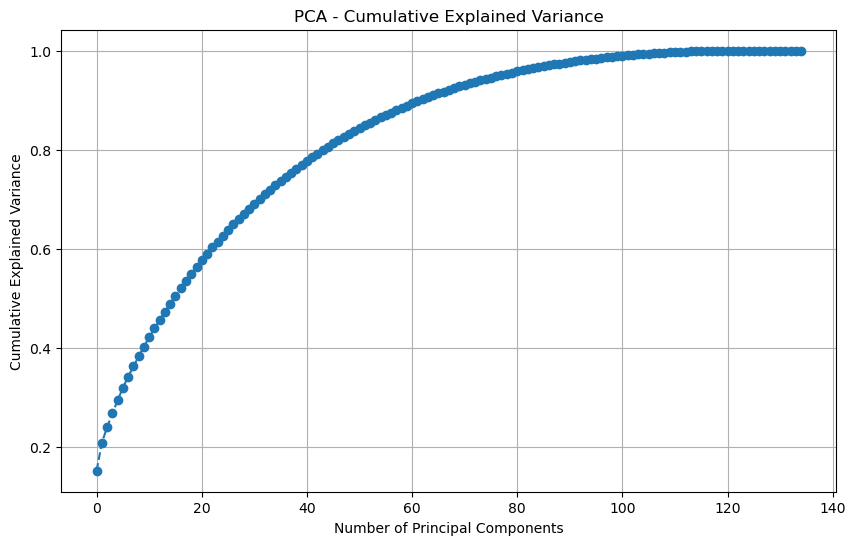

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def process_PCA(df):
    # Extract features and standardize
    features = df.drop(columns='Sensor ID')
    sensor_ids = df['Sensor ID']

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform PCA
    pca = PCA()
    principal_components = pca.fit_transform(features_scaled)

    # Explained variance ratio for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance to see the importance of each component
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Get the loadings (coefficients) of the features on the principal components
    loadings = pca.components_

    # Display the loadings for the first few principal components
    return explained_variance, loadings, features

explained_variance, loadings, features = process_PCA(df_range_delay_all)



In [23]:
# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features.columns)
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_middle,-0.155435,0.103062,0.056253,0.007238,-0.002885,-0.012317,0.084118,0.050300,-0.052938,-0.044208,...,-0.264301,0.293396,-0.078902,-0.071756,0.416438,0.116277,-0.166110,-0.045158,-0.003739,0.073611
13_16800_mean_middle,0.027520,-0.006745,0.069394,0.024238,0.196916,0.060269,0.060799,0.072068,0.218573,-0.107597,...,-0.022458,0.013862,-0.002914,-0.008208,0.007852,0.000010,0.020961,0.009173,0.005566,-0.017291
13_3000_mean_middle,-0.105927,-0.082551,0.080120,0.014534,0.026873,0.024420,0.128643,0.057756,-0.009948,-0.125762,...,0.049823,-0.044724,-0.036728,-0.008656,-0.015597,0.019058,-0.029059,0.002414,0.013251,0.006934
13_6000_mean_middle,-0.085277,0.057006,0.030500,-0.079506,-0.053961,0.096651,0.091018,0.053567,0.029495,-0.158074,...,0.202869,0.098118,0.017770,-0.055537,-0.019294,0.249613,0.029045,0.136598,0.044432,0.014647
13_8000_mean_middle,-0.156561,0.101169,0.052338,-0.001526,0.004899,-0.009297,0.097002,0.051088,-0.045435,-0.048727,...,0.109887,-0.316796,0.099194,0.106294,-0.406539,-0.215194,0.203169,-0.013275,-0.019090,-0.086995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,-0.008606,0.074721,0.094664,0.151184,0.096501,0.084728,-0.087695,-0.113330,0.061504,-0.035861,...,0.018010,-0.024735,-0.025271,0.023983,0.006507,-0.003807,0.030336,0.009725,-0.013656,0.010083
53_16800_mean_upper,0.010644,0.023174,0.138260,0.058733,-0.043115,0.032059,-0.053248,-0.192493,-0.113012,-0.123791,...,-0.005946,0.010048,0.017546,0.015499,-0.008921,0.018255,-0.023698,0.016894,-0.007927,0.009704
53_3000_mean_upper,-0.015113,-0.016464,0.099077,0.070065,0.015420,-0.033703,0.112746,-0.175795,0.077035,0.132073,...,-0.011310,-0.001281,-0.002030,0.002819,0.010691,0.007997,-0.020925,0.007025,0.007752,-0.010895


In [24]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings = loadings[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance = np.sum(np.abs(selected_loadings), axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features = feature_importance_df.head(50)

top_features

,Feature,Importance
56,23_16800_mean_lower,5.463906
115,38_10000_mean_upper,5.376003
101,23_16800_mean_upper,5.247711
57,23_3000_mean_lower,5.212668
102,23_3000_mean_upper,5.170999
118,38_6000_mean_upper,5.170678
91,13_16800_mean_upper,5.131967
13,23_6000_mean_middle,5.129321
79,43_8000_mean_lower,5.127778
43,53_6000_mean_middle,5.098241


Having many features with an importance score over 1 can be interpreted in various ways.

Implication 1: Distributed Contribution
- Distributed Contribution: When many features have high importance scores, it indicates that the variance in the data is distributed across multiple features rather than being dominated by a few.
- Balanced Influence: This suggests a balanced influence where no single feature overwhelmingly explains the variance, but rather, multiple features contribute significantly.

Implication 2: Multicollinearity
- Multicollinearity: It might indicate the presence of multicollinearity, where multiple features are correlated with each other and together contribute to the same principal components.
- Redundancy: In such cases, there might be redundancy in the information provided by these features



To address these issues we could look into correlation matrix and use regularization technique to reduce it

## Investigate Multicollinearity

### Analyze using correlation matrix

In [25]:
# List of DataFrames
df_pivots = [df_range_delay_lower, df_range_delay_upper]

# Initialize the merged DataFrame with the first DataFrame in the list
df_range_delay_ends = df_pivots[0]

# Iteratively merge each DataFrame in the list
for df in df_pivots[1:]:
    df_range_delay_ends = df_range_delay_ends.merge(df, on='Sensor ID')
# Replace all NaN values with 0 in the merged DataFrame
df_range_delay_ends.fillna(0, inplace=True)

In [26]:
df_range_delay_corr= df_range_delay_ends.drop(["Sensor ID"], axis = 1)

In [27]:
# Calculate the correlation matrix for the dataset
correlation_matrix = df_range_delay_corr.corr()
correlation_matrix


range_delay,13_10000_mean_lower,13_16800_mean_lower,13_3000_mean_lower,13_6000_mean_lower,13_8000_mean_lower,18_10000_mean_lower,18_16800_mean_lower,18_3000_mean_lower,18_6000_mean_lower,18_8000_mean_lower,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_lower,1.000000,-0.076172,0.240773,0.233951,0.336649,0.063161,0.103534,0.127043,0.054115,0.156076,...,-0.137357,-0.019695,0.031646,-0.063437,-0.046176,0.050077,0.049168,0.047523,-0.165733,-0.135859
13_16800_mean_lower,-0.076172,1.000000,0.069793,0.004841,0.079819,0.243768,0.029012,0.082026,0.126755,-0.014737,...,0.019305,-0.029272,-0.068612,-0.050305,-0.025251,-0.004213,0.087255,-0.021815,0.140318,-0.013815
13_3000_mean_lower,0.240773,0.069793,1.000000,0.297573,0.291566,0.076708,0.136616,0.144030,0.029114,0.103739,...,-0.013931,0.123588,0.020503,0.020248,0.024361,0.112028,0.042072,0.028243,0.153642,0.001631
13_6000_mean_lower,0.233951,0.004841,0.297573,1.000000,0.381451,0.000969,0.010833,0.079787,0.079060,0.003997,...,-0.051726,-0.016466,-0.003061,-0.044076,0.037023,0.008043,0.003738,-0.055023,0.066125,-0.126378
13_8000_mean_lower,0.336649,0.079819,0.291566,0.381451,1.000000,0.114793,0.050736,0.166374,0.080506,0.077381,...,-0.073007,0.031802,-0.035557,-0.118591,-0.006247,-0.006338,0.026343,-0.081335,0.041180,-0.099738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,0.050077,-0.004213,0.112028,0.008043,-0.006338,-0.059448,0.052034,-0.018095,0.008323,-0.008894,...,0.099204,0.031948,0.030633,0.002941,0.033994,1.000000,0.067735,0.170317,0.230532,0.358396
53_16800_mean_upper,0.049168,0.087255,0.042072,0.003738,0.026343,0.037123,0.058431,-0.058679,0.017005,0.023331,...,-0.001144,0.059057,-0.090171,-0.068626,-0.056557,0.067735,1.000000,-0.001761,0.198966,0.066020
53_3000_mean_upper,0.047523,-0.021815,0.028243,-0.055023,-0.081335,-0.018774,0.147372,-0.091549,-0.118118,-0.042414,...,-0.028976,-0.066747,0.027828,0.066973,0.142163,0.170317,-0.001761,1.000000,0.138534,0.116706


In [28]:
# Extract pairs of highly correlated features with correlation coefficient above a threshold (e.g., 0.8 or below -0.8)
threshold = 0.6
highly_correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(feature_pair)

# Convert the list of tuples to a DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
highly_correlated_df


,Feature 1,Feature 2,Correlation
0,43_16800_mean_lower,43_16800_mean_upper,0.615191
1,53_3000_mean_lower,53_3000_mean_upper,0.620308


In [29]:
def drop_highly_correlated_features(df, threshold=0.8):
    """
    Drops highly positively correlated features from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The correlation threshold for dropping features. Defaults to 0.8.
    
    Returns:
    pd.DataFrame: DataFrame with highly positively correlated features removed.
    list: List of dropped features.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Identify highly positively correlated pairs
    to_drop = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]
                to_drop.add(colname)
    
    # Drop the identified features
    reduced_df = df.drop(columns=to_drop)
    
    return reduced_df, list(to_drop)

# Apply the function to the dataset
reduced_data_corr, dropped_features_corr = drop_highly_correlated_features(df_range_delay_ends, threshold=0.7)

reduced_data_corr

range_delay,Sensor ID,13_10000_mean_lower,13_16800_mean_lower,13_3000_mean_lower,13_6000_mean_lower,13_8000_mean_lower,18_10000_mean_lower,18_16800_mean_lower,18_3000_mean_lower,18_6000_mean_lower,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,1,826.520000,826.166667,826.346939,826.360000,826.510204,1070.040000,1059.000000,0.000000,0.0,...,2795.000000,0.0,2809.400000,2803.000000,2800.333333,2995.545455,0.000000,2995.444444,3039.727273,3004.043478
1,2,0.000000,678.600000,678.500000,678.904762,678.510204,942.166667,0.000000,943.000000,0.0,...,2669.521739,0.0,0.000000,0.000000,2691.000000,0.000000,2371.000000,0.000000,2951.744186,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,0.000000,1005.736842,0.0,...,0.000000,0.0,2743.000000,2727.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,1023.000000,1029.818182,0.000000,1030.2,...,0.000000,0.0,0.000000,2755.195122,0.000000,3000.000000,3019.000000,3000.116279,2999.930233,3000.116279
4,5,742.348837,718.333333,0.000000,742.619048,742.428571,0.000000,1024.142857,1023.000000,1022.2,...,0.000000,2755.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
206,208,0.000000,0.000000,0.000000,0.000000,718.789474,0.000000,0.000000,0.000000,0.0,...,2738.333333,0.0,2739.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207,209,758.272727,0.000000,758.600000,751.000000,0.000000,0.000000,1029.909091,0.000000,0.0,...,0.000000,2782.0,2779.000000,2778.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208,210,0.000000,0.000000,721.769231,722.000000,0.000000,1018.090909,0.000000,0.000000,0.0,...,0.000000,0.0,2743.000000,0.000000,0.000000,0.000000,3037.666667,3016.743590,0.000000,0.000000


In [30]:
dropped_features_corr

[]

In [31]:
def plot_pca_interactive(data, sensor_id_col='Sensor ID', n_components=2):
    """
    Plots an interactive scatter plot using PCA components.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing features and Sensor ID.
    sensor_id_col (str): The name of the column containing sensor IDs.
    n_components (int): Number of principal components to compute.

    Returns:
    None: Displays an interactive Plotly scatter plot.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data.drop(columns=[sensor_id_col]))

    # Create a DataFrame with the principal components and Sensor ID
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    principal_df[sensor_id_col] = data[sensor_id_col]

    # Create an interactive scatter plot using Plotly
    fig = px.scatter(
        principal_df,
        x='PC1',
        y='PC2',
        color=sensor_id_col,
        title='Sensors Visualized Using Principal Components',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        hover_data=[sensor_id_col]
    )

    # Show the plot
    fig.show()

In [32]:
# Plot the PCA interactive plot
plot_pca_interactive(df_range_delay_ends, sensor_id_col='Sensor ID', n_components=2)

Try PCA on reduced data

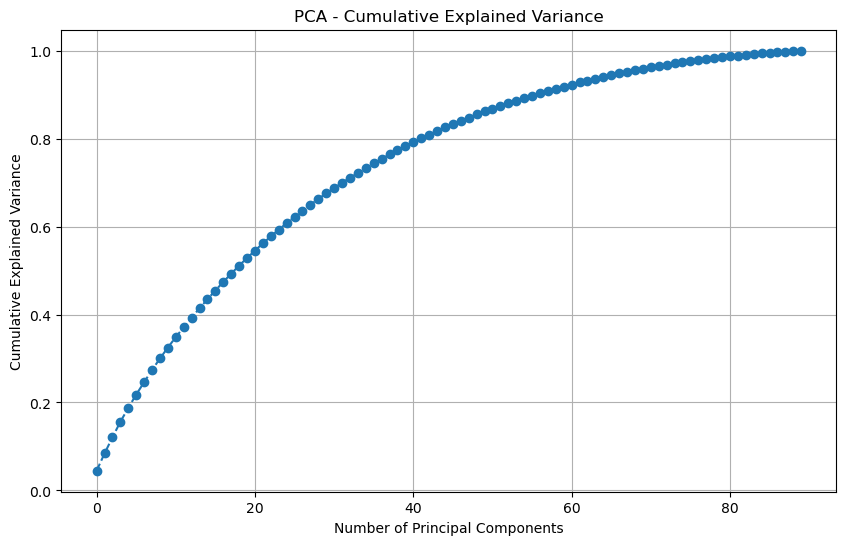

In [33]:
explained_variance_corr, loadings_corr, features_corr = process_PCA(reduced_data_corr)

In [34]:
# Create a DataFrame for the loadings
loading_df_corr = pd.DataFrame(loadings_corr.T, columns=[f'PC{i+1}' for i in range(loadings_corr.shape[0])], index=features_corr.columns)
loading_df_corr

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
range_delay,,,,,,,,,,,,,,,,,,,,,
13_10000_mean_lower,0.206418,-0.111102,-0.093604,-0.154164,-0.079718,-0.014302,-0.020511,-0.121065,0.022295,-0.133200,...,0.058976,-0.059346,-0.064298,-0.139921,0.029343,-0.066132,0.118269,-0.064218,-0.000136,0.104982
13_16800_mean_lower,0.092051,-0.061855,0.067967,0.101970,-0.071373,0.093714,-0.013083,-0.046278,0.003305,0.061338,...,0.113045,-0.120539,-0.068726,-0.033640,0.126536,0.093142,0.094161,-0.184689,-0.017199,-0.012454
13_3000_mean_lower,0.251890,-0.095291,-0.109272,0.043669,-0.029004,-0.024480,-0.183610,-0.023942,-0.111702,-0.041659,...,0.090286,0.006445,-0.044412,0.055853,-0.171424,0.068332,0.081636,0.219969,0.068700,0.185173
13_6000_mean_lower,0.173220,-0.127105,-0.131493,-0.131929,-0.077441,-0.120467,-0.056602,-0.011880,-0.092928,0.014300,...,-0.066446,-0.156980,-0.051210,-0.015666,-0.010645,0.174463,-0.128489,-0.066169,-0.002633,0.042143
13_8000_mean_lower,0.230161,-0.118297,-0.116838,-0.152533,-0.095017,-0.052052,-0.029191,-0.084027,-0.038623,0.105318,...,0.035271,0.025923,-0.018181,0.212349,0.207440,-0.210295,0.029637,-0.033524,0.052576,-0.271517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53_10000_mean_upper,0.072662,0.159905,-0.154212,0.132908,-0.024547,0.089716,-0.173264,-0.065373,0.029028,-0.096582,...,-0.126607,-0.179332,-0.047198,0.049565,-0.052162,0.144485,0.055715,-0.047110,-0.120256,-0.042233
53_16800_mean_upper,0.106748,0.074101,0.012856,0.067118,0.023554,0.221999,0.158681,-0.138212,0.044414,-0.086769,...,0.014347,0.021132,0.023965,-0.004571,-0.030920,-0.057940,-0.038806,-0.111982,-0.034568,0.068310
53_3000_mean_upper,0.060319,0.082574,-0.010428,-0.009867,0.229106,0.070548,-0.204012,0.080654,-0.045762,-0.201358,...,-0.106001,0.139580,0.056149,-0.122526,0.022757,-0.035766,0.109411,-0.010901,0.288318,0.011778


In [35]:
# Determine the number of components to retain 90% variance
cumulative_variance = np.cumsum(explained_variance_corr)
num_components = np.argmax(cumulative_variance >= 0.9) + 1

# Get the loadings for the selected components
selected_loadings_corr = loadings_corr[:num_components, :]

# Calculate the importance of each feature by summing the absolute values of its loadings across the selected components
feature_importance_corr = np.sum(np.abs(selected_loadings_corr), axis=0)

# Create a DataFrame for feature importance
feature_importance_df_corr = pd.DataFrame({'Feature': features_corr.columns, 'Importance': feature_importance_corr})

# Sort the features by importance
feature_importance_df_corr = feature_importance_df_corr.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features_corr = feature_importance_df_corr.head(200)

top_features_corr

,Feature,Importance
46,13_16800_mean_upper,5.573829
56,23_16800_mean_upper,5.451900
39,48_8000_mean_lower,5.442802
29,38_8000_mean_lower,5.382545
6,18_16800_mean_lower,5.365498
...,...,...
42,53_3000_mean_lower,4.294474
66,33_16800_mean_upper,4.290006
15,28_10000_mean_lower,4.283666
8,18_6000_mean_lower,4.202191


In [36]:
# Plot the PCA interactive plot
plot_pca_interactive(reduced_data_corr, sensor_id_col='Sensor ID', n_components=2)

## Clustering

In [37]:
from sklearn.cluster import KMeans

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(reduced_data_corr.drop(columns=['Sensor ID']))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df['Sensor ID'] = reduced_data_corr['Sensor ID']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
principal_df['Cluster'] = kmeans.fit_predict(principal_df[['PC1', 'PC2', 'PC3']])

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    principal_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    symbol='Sensor ID',
    title='K-Means Clustering of Sensors Using PCA',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    hover_data=['Sensor ID']
)

fig.show()

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



# Retain Features that previously existed

In [38]:
df_range_delay_all.head()

range_delay,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_mean_upper,48_16800_mean_upper,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,2795.000000,0.0,2809.4,2803.000000,2800.333333,2995.545455,0.0,2995.444444,3039.727273,3004.043478
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,2669.521739,0.0,0.0,0.000000,2691.000000,0.000000,2371.0,0.000000,2951.744186,0.000000
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,0.000000,0.0,2743.0,2727.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.000000,0.0,0.0,2755.195122,0.000000,3000.000000,3019.0,3000.116279,2999.930233,3000.116279
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.000000,2755.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [39]:
# Group the merged data by 'Sensor ID'
grouped_data = df_data_v4_1_1.groupby("Sensor ID")

# Function to get unique values of categorical columns for each group
def get_unique_categorical_values(group):
    unique_values = {}
    for column in group.select_dtypes(include=['object']).columns:
        unique_values[column] = group[column].unique().tolist()
    return unique_values

# Apply the function to each group and collect the results
unique_categorical_values = grouped_data.apply(get_unique_categorical_values).to_dict()

unique_categorical_values

{1: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 2: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 3: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 4: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 5: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 6: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 7: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 8: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 9: {'Color of sensor': ['g'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 10: {'Color of sensor': ['b'],
  'Sensor Configuration': ['HTR'],
  'Surface material': ['wood']},
 11: {'Co

In [40]:
unique_categorical_values_df = pd.DataFrame.from_dict(unique_categorical_values, orient='index')

# Convert list values to strings and keep Sensor ID as index
unique_categorical_values_df = unique_categorical_values_df.applymap(lambda x: x[0] if isinstance(x, list) else x)
unique_categorical_values_df.reset_index(inplace=True)

# Rename the 'index' column to 'Sensor ID'
unique_categorical_values_df.rename(columns={'index': 'Sensor ID'}, inplace=True)

# Display the updated DataFrame
unique_categorical_values_df.head()

C:\Users\Jihoon.DESKTOP-1HIBMQO\AppData\Local\Temp\ipykernel_10788\718001310.py:4: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Sensor ID,Color of sensor,Sensor Configuration,Surface material
0,1,b,HTR,wood
1,2,b,HTR,wood
2,3,b,HTR,wood
3,4,g,HTR,wood
4,5,b,HTR,wood


In [41]:
# One-hot encode all the object features
if not unique_categorical_values_df.empty:
    unique_categorical_values_encoded = pd.get_dummies(unique_categorical_values_df, drop_first=True)
else:
    unique_categorical_values_encoded = unique_categorical_values_df


# Convert boolean columns to integers (0 and 1)
unique_categorical_values_encoded["Color of sensor_g"] = unique_categorical_values_encoded["Color of sensor_g"].astype(int)
unique_categorical_values_encoded

,Sensor ID,Color of sensor_g,Color of sensor_g5
0,1,0,False
1,2,0,False
2,3,0,False
3,4,1,False
4,5,0,False
...,...,...,...
205,207,0,False
206,208,0,False
207,209,0,False
208,210,0,False


In [42]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_range_delay_all, unique_categorical_values_encoded, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_3000_mean_upper,48_6000_mean_upper,48_8000_mean_upper,53_10000_mean_upper,53_16800_mean_upper,53_3000_mean_upper,53_6000_mean_upper,53_8000_mean_upper,Color of sensor_g,Color of sensor_g5
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,2809.4,2803.000000,2800.333333,2995.545455,0.0,2995.444444,3039.727273,3004.043478,0,False
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,0.0,0.000000,2691.000000,0.000000,2371.0,0.000000,2951.744186,0.000000,0,False
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,2743.0,2727.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,False
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.0,2755.195122,0.000000,3000.000000,3019.0,3000.116279,2999.930233,3000.116279,1,False
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,False


# Upper and Lower bound's Frequency (Feature Engineering)

In [43]:
# Group by 'Sensor ID' and 'Delay (us)' for lower quartile
grouped_lower_outliers = df_lower_quartile.groupby(['Sensor ID', 'Delay (us)'])['Ping Time (us)'].count().reset_index()

# Group by 'Sensor ID' and 'Delay (us)' for upper quartile
grouped_upper_outliers = df_upper_quartile.groupby(['Sensor ID', 'Delay (us)'])['Ping Time (us)'].count().reset_index()

# Merge the grouped dataframes with alias column names for the count columns
df_outlier_freq = pd.merge(grouped_lower_outliers, grouped_upper_outliers, on=['Sensor ID', 'Delay (us)'], suffixes=('_lower', '_upper'), how='left')

# Rename the columns if necessary
df_outlier_freq.rename(columns={
    'Ping Time (us)_lower': 'Lower Quartile Ping Count',
    'Ping Time (us)_upper': 'Upper Quartile Ping Count'
}, inplace=True)


# Replace NaN values with 0
df_outlier_freq.fillna(0, inplace=True)

df_outlier_freq['Lower Quartile Ping Count'] = df_outlier_freq['Lower Quartile Ping Count'].astype(int)
df_outlier_freq['Upper Quartile Ping Count'] = df_outlier_freq['Upper Quartile Ping Count'].astype(int)


# Display the resulting DataFrame
df_outlier_freq.head()

,Sensor ID,Delay (us),Lower Quartile Ping Count,Upper Quartile Ping Count
0,1,3000,140,131
1,1,6000,171,182
2,1,8000,167,197
3,1,10000,267,258
4,1,16800,102,105


In [44]:
df_outlier_freq['delay_freq'] =  "delay"+ '_' + df_outlier_freq['Delay (us)'].astype(str)+'_'+"freq"+'_'+"lower"

# Step 3: Pivot the table
df_pivot_lower = df_outlier_freq.pivot(index='Sensor ID', columns='delay_freq', values='Lower Quartile Ping Count').reset_index()

df_pivot_lower.head()

delay_freq,Sensor ID,delay_10000_freq_lower,delay_16800_freq_lower,delay_3000_freq_lower,delay_6000_freq_lower,delay_8000_freq_lower
0,1,267.0,102.0,140.0,171.0,167.0
1,2,174.0,55.0,129.0,164.0,131.0
2,3,5.0,6.0,48.0,10.0,8.0
3,4,42.0,136.0,76.0,148.0,41.0
4,5,98.0,22.0,95.0,130.0,137.0


In [45]:
df_outlier_freq['delay_freq'] =  "delay"+ '_' + df_outlier_freq['Delay (us)'].astype(str)+'_'+"freq"+'_'+"upper"

# Step 3: Pivot the table
df_pivot_upper = df_outlier_freq.pivot(index='Sensor ID', columns='delay_freq', values='Upper Quartile Ping Count').reset_index()

df_pivot_upper.head()

delay_freq,Sensor ID,delay_10000_freq_upper,delay_16800_freq_upper,delay_3000_freq_upper,delay_6000_freq_upper,delay_8000_freq_upper
0,1,258.0,105.0,131.0,182.0,197.0
1,2,172.0,59.0,143.0,194.0,145.0
2,3,21.0,13.0,52.0,8.0,11.0
3,4,57.0,127.0,90.0,150.0,49.0
4,5,91.0,13.0,82.0,139.0,128.0


In [46]:
df_delay_freq = pd.merge(df_pivot_lower,df_pivot_upper, on='Sensor ID',how='left')
# Replace NaN values with 0
df_delay_freq.fillna(0, inplace=True)
df_delay_freq = df_delay_freq.astype(int)

df_delay_freq

delay_freq,Sensor ID,delay_10000_freq_lower,delay_16800_freq_lower,delay_3000_freq_lower,delay_6000_freq_lower,delay_8000_freq_lower,delay_10000_freq_upper,delay_16800_freq_upper,delay_3000_freq_upper,delay_6000_freq_upper,delay_8000_freq_upper
0,1,267,102,140,171,167,258,105,131,182,197
1,2,174,55,129,164,131,172,59,143,194,145
2,3,5,6,48,10,8,21,13,52,8,11
3,4,42,136,76,148,41,57,127,90,150,49
4,5,98,22,95,130,137,91,13,82,139,128
...,...,...,...,...,...,...,...,...,...,...,...
205,207,93,3,43,46,44,86,2,44,50,42
206,208,38,13,46,45,77,51,27,72,58,105
207,209,55,25,51,42,59,56,30,55,63,70
208,210,129,5,211,128,23,119,27,214,122,11


In [47]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_all, df_delay_freq, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,delay_10000_freq_lower,delay_16800_freq_lower,delay_3000_freq_lower,delay_6000_freq_lower,delay_8000_freq_lower,delay_10000_freq_upper,delay_16800_freq_upper,delay_3000_freq_upper,delay_6000_freq_upper,delay_8000_freq_upper
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,267,102,140,171,167,258,105,131,182,197
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,174,55,129,164,131,172,59,143,194,145
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,5,6,48,10,8,21,13,52,8,11
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,42,136,76,148,41,57,127,90,150,49
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,98,22,95,130,137,91,13,82,139,128


# Add Variability (Feature Engineering)

In [48]:

def create_range_delay_feature_variability(df_quartile,bound):
    # Step 1: Group and calculate mean
    df_grouped = df_quartile.groupby(['Sensor ID', 'Range (cm)', 'Delay (us)'])['Ping Time (us)'].var().reset_index()

    # Step 2: Create `range_delay` column
    df_grouped['range_delay_var'] = df_grouped['Range (cm)'].astype(str) + '_' + df_grouped['Delay (us)'].astype(str)+'_'+'var'+'_'+bound

    # Step 3: Pivot the table
    df_pivot = df_grouped.pivot(index='Sensor ID', columns='range_delay_var', values='Ping Time (us)').reset_index()
    
    return df_pivot


def feature_engineering_quartile_var(df):
    df_middle_quartile, df_lower_quartile, df_upper_quartile = split_quartiles(df)
    df_range_delay_middle = create_range_delay_feature_variability(df_middle_quartile,"middle")
    df_range_delay_lower = create_range_delay_feature_variability(df_lower_quartile,"lower")
    df_range_delay_upper = create_range_delay_feature_variability(df_upper_quartile,"upper")

    # List of DataFrames
    df_pivots = [df_range_delay_middle, df_range_delay_lower, df_range_delay_upper]

    # Initialize the merged DataFrame with the first DataFrame in the list
    df_range_delay_all = df_pivots[0]

    # Iteratively merge each DataFrame in the list
    for df in df_pivots[1:]:
        df_range_delay_all = df_range_delay_all.merge(df, on='Sensor ID')
        
    # Replace all NaN values with 0 in the merged DataFrame
    df_range_delay_all.fillna(0, inplace=True)

    return df_range_delay_all, df_range_delay_middle, df_range_delay_lower,df_range_delay_upper
    

df_range_delay_var_all,df_range_delay_var_middle, df_range_delay_var_lower,df_range_var_delay_upper = feature_engineering_quartile_var(df_data_v4_1_1)


In [49]:
df_range_delay_var_all.head()

range_delay_var,Sensor ID,13_10000_var_middle,13_16800_var_middle,13_3000_var_middle,13_6000_var_middle,13_8000_var_middle,18_10000_var_middle,18_16800_var_middle,18_3000_var_middle,18_6000_var_middle,...,48_10000_var_upper,48_16800_var_upper,48_3000_var_upper,48_6000_var_upper,48_8000_var_upper,53_10000_var_upper,53_16800_var_upper,53_3000_var_upper,53_6000_var_upper,53_8000_var_upper
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.333333,8.594286,6.530612,...,0.000000,0.0,172.8,288.000000,165.333333,1.928118,0.0,1.616162,137.018182,362.975845
1,2,5.459592,0.000000,0.000000,0.000000,0.000000,0.000000,189.387755,7.397101,164.336327,...,36.521739,0.0,0.0,0.000000,11.636364,0.000000,144840.0,0.000000,4.004430,0.000000
2,3,4.597551,5.040169,4.937143,6.635102,6.243265,4.654545,136.646531,0.000000,7.712653,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4,4.075102,6.014694,5.361633,5.381224,5.936327,3.123123,0.000000,6.014694,35.096774,...,0.000000,0.0,0.0,1.560976,0.000000,3.069767,0.0,3.295681,2.923588,3.295681
4,5,0.000000,6.475107,5.250612,0.000000,0.000000,8.843537,8.168328,8.272109,5.301010,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [50]:
# Merge the unique categorical values DataFrame with the original data on 'Sensor ID'
df_all = pd.merge(df_all, df_range_delay_var_all, on='Sensor ID', how='left')
df_all.head()

,Sensor ID,13_10000_mean_middle,13_16800_mean_middle,13_3000_mean_middle,13_6000_mean_middle,13_8000_mean_middle,18_10000_mean_middle,18_16800_mean_middle,18_3000_mean_middle,18_6000_mean_middle,...,48_10000_var_upper,48_16800_var_upper,48_3000_var_upper,48_6000_var_upper,48_8000_var_upper,53_10000_var_upper,53_16800_var_upper,53_3000_var_upper,53_6000_var_upper,53_8000_var_upper
0,1,827.00,827.000000,827.00,827.00,827.00,1071.000000,1069.285714,1069.240000,1069.400000,...,0.000000,0.0,172.8,288.000000,165.333333,1.928118,0.0,1.616162,137.018182,362.975845
1,2,679.64,679.000000,679.00,679.00,679.00,943.000000,954.200000,967.260870,954.520000,...,36.521739,0.0,0.0,0.000000,11.636364,0.000000,144840.0,0.000000,4.004430,0.000000
2,3,717.88,717.727273,718.04,717.24,718.04,1029.933333,1020.920000,1007.000000,1005.960000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4,737.08,736.840000,737.16,736.92,736.68,1030.351351,1031.000000,1028.840000,1087.000000,...,0.000000,0.0,0.0,1.560976,0.000000,3.069767,0.0,3.295681,2.923588,3.295681
4,5,743.00,742.894737,741.88,743.00,743.00,1046.102041,1045.697674,1047.244898,1046.288889,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [51]:
df_all["Sensor ID"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

# Export data

In [52]:
#df_all.to_csv("../processed_data/data_v4-1-1_feature_engineered_sensor210.csv", index=False)